In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import constants, units
from astropy.coordinates import Angle
from scipy.optimize import curve_fit
import pandas as pd
import os
from scipy.signal import medfilt
from astropy.wcs import WCS
import scipy.integrate as integrate
import re

In [2]:
rootdir = '/Users/thepoetoftwilight/Documents/CUBS/Data/FBQS0751+2919/HST_images/'

Load in the quasar and the alignment star

In [3]:
with open(rootdir+'alignment_stars.reg', 'r') as file:
    qso_star_lines = [line.rstrip() for line in file]

In [4]:
star_lines = []

for l in qso_star_lines:
    if 'circle' in l:
        if 'cyan' in l:
            qso_line = l
        else:
            star_lines.append(l)

In [5]:
qso_ra = np.float_(qso_line.split(',')[0][7:])
qso_dec = np.float_(qso_line.split(',')[1])

In [6]:
star_ra_list = []
star_dec_list = []

for i in range(len(star_lines)):
    star_ra_list.append(star_lines[i].split(',')[0][7:])
    star_dec_list.append(star_lines[i].split(',')[1])

Load in the photometry catalog

In [7]:
df = pd.read_csv(rootdir+'f814w_photometry.dat')

In [8]:
df

,ID,RA,Dec,f814w_mag
0,1,117.837191,29.323495,22.93
1,2,117.838687,29.323272,22.33
2,3,117.835662,29.312494,18.43
3,4,117.842144,29.343727,21.29
4,5,117.842846,29.343055,24.94
...,...,...,...,...
15569,99,117.781541,29.357355,24.26
15570,100,117.780039,29.352868,25.09
15571,101,117.780277,29.353948,25.26
15572,102,117.778879,29.302126,22.09


Identify the alignment stars in the catalog

In [9]:
def calc_phi(alpha_1, delta_1, alpha_2, delta_2):
    
    cos_phi = np.dot([np.cos(delta_1)*np.cos(alpha_1), np.cos(delta_1)*np.sin(alpha_1), np.sin(delta_1)],
                      [np.cos(delta_2)*np.cos(alpha_2), np.cos(delta_2)*np.sin(alpha_2), np.sin(delta_2)])
    
    phi = np.arccos(cos_phi)
    
    return phi

In [10]:
df['alignment_star'] = -1*np.ones(len(df))

In [11]:
for i in range(len(star_ra_list)):
    
    star_ra = Angle(star_ra_list[i], units.deg).rad
    star_dec = Angle(star_dec_list[i], units.deg).rad
    
    phi_arr = np.zeros(len(df))
    
    for j in range(len(df)):
        
        ra = Angle(df.loc[j, 'RA'], units.deg).rad
        dec = Angle(df.loc[j, 'Dec'], units.deg).rad
        
        phi = (calc_phi(star_ra, star_dec, ra, dec)*units.rad).to(units.arcsecond).value
        
        phi_arr[j] = phi
        
    df.loc[np.argmin(phi_arr), 'alignment_star'] = 1.0

Compute distances of all objects from the quasar

In [12]:
df['theta'] = -1*np.ones(len(df))

In [13]:
theta_arr = np.zeros(len(df))

for i in range(len(df)):

    ra = Angle(df.loc[i, 'RA'], units.deg).rad
    dec = Angle(df.loc[i, 'Dec'], units.deg).rad    
    
    theta_arr[i] = (calc_phi(ra, dec, qso_ra*np.pi/180, qso_dec*np.pi/180)*units.rad).to(units.arcsecond).value
    
df['theta'] = theta_arr

In [14]:
df

,ID,RA,Dec,f814w_mag,alignment_star,theta
0,1,117.837191,29.323495,22.93,-1.0,113.603020
1,2,117.838687,29.323272,22.33,-1.0,118.363305
2,3,117.835662,29.312494,18.43,-1.0,120.379891
3,4,117.842144,29.343727,21.29,-1.0,141.342681
4,5,117.842846,29.343055,24.94,-1.0,142.364006
...,...,...,...,...,...,...
15569,99,117.781541,29.357355,24.26,-1.0,124.738218
15570,100,117.780039,29.352868,25.09,-1.0,113.696494
15571,101,117.780277,29.353948,25.26,-1.0,116.447311
15572,102,117.778879,29.302126,22.09,-1.0,114.565842


Sort now by $\theta$ and magnitudes

In [15]:
fig, ax = plt.subplots(1, figsize=(15,7))
ax.hist(df['theta'], bins=40)

ax.set_xlabel(r'$\theta$ (arcseconds)')
ax.set_ylabel('Counts')

Text(0, 0.5, 'Counts')

Error in callback <function flush_figures at 0x7fc5201a4310> (for post_execute):


KeyboardInterrupt: 

In [16]:
theta_partitions = [0,40,80,120,165]

In [17]:
df_sorted = pd.DataFrame(columns=df.columns)

In [18]:
for i in range(len(theta_partitions)-1):
    
    theta_min = theta_partitions[i]
    theta_max = theta_partitions[i+1]
    
    df_slice = df.loc[(df['theta']>=theta_min)&(df['theta']<=theta_max)].sort_values('f814w_mag')
        
    df_sorted = df_sorted.append(df_slice)

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_4796/136537916.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sorted = df_sorted.append(df_slice)
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_4796/136537916.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sorted = df_sorted.append(df_slice)
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_4796/136537916.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sorted = df_sorted.append(df_slice)
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_4796/136537916.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sorted = df_sorted.a

In [19]:
df_sorted

,ID,RA,Dec,f814w_mag,alignment_star,theta
7772,7773,117.801164,29.336475,15.50,-1.0,33.149419
7773,7774,117.801269,29.327298,15.82,-1.0,0.119356
9149,9150,117.794011,29.320549,18.32,1.0,33.195566
8109,8110,117.800330,29.320804,19.03,1.0,23.448562
5405,5406,117.812242,29.326376,19.34,-1.0,34.632784
...,...,...,...,...,...,...
58,59,117.842380,29.338948,29.07,-1.0,135.745328
13660,59,117.841994,29.341501,29.07,-1.0,137.740210
13976,375,117.829672,29.350940,29.20,-1.0,123.350988
374,375,117.833765,29.301038,29.20,-1.0,139.032127


Now, retain only the galaxies between a magnitude of 14 and 21

In [20]:
df_gals = df_sorted.loc[((df_sorted['f814w_mag']>=14)&(df_sorted['f814w_mag']<=21))&(df_sorted['alignment_star']==-1.0)]

In [21]:
df_gals = df_gals.append(df.loc[[8842, 8059, 7808, 7869, 7715, 8294, 
                                 8893, 6494, 8531, 7874, 8084, 8374]])

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_4796/558023747.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gals = df_gals.append(df.loc[[8842, 8059, 7808, 7869, 7715, 8294,


In [22]:
ra_sorted = []
dec_sorted = []
theta_sorted = []
mag_sorted = []

In [23]:
for i in range(len(theta_partitions)-1):
    
    theta_min = theta_partitions[i]
    theta_max = theta_partitions[i+1]
    
    df_slice = df_gals.loc[(df_gals['theta']>=theta_min)&(df_gals['theta']<=theta_max)].sort_values('f814w_mag')
            
    theta_sorted.append(list(df_slice['theta']))
    mag_sorted.append(list(df_slice['f814w_mag']))
    ra_sorted.append(list(df_slice['RA']))
    dec_sorted.append(list(df_slice['Dec']))

Next, the galaxies. First assign priority scores to the galaxies. The brightest galaxy in the closest bin to the quasar will have a priority of -1, while the dimmest will have a priority of +1.

In [24]:
priorities_sorted = []

In [25]:
count = 0
bin_size = len(theta_sorted[0])

for i in range(len(theta_sorted)):
    priorities_sorted.append([])
    for j in range(len(theta_sorted[i])):
        
        priorities_sorted[i].append(-1 + 2*(count/(bin_size-1)))
        
        # This puts the brightest closest galaxy at -1 and the dimmest farthest at 1
        #priorities_sorted[i].append(-1 + 2*(count/(N_gals-1)))
        count += 1

Plot the distribution of galaxy magnitudes in each bin away from the quasar

In [26]:
colors = ['salmon', 'olive', 'sandybrown', 'lightblue', 'violet']

In [27]:
N_gals = 0

20
28
25
9


Text(0, 0.5, 'Magnitude')

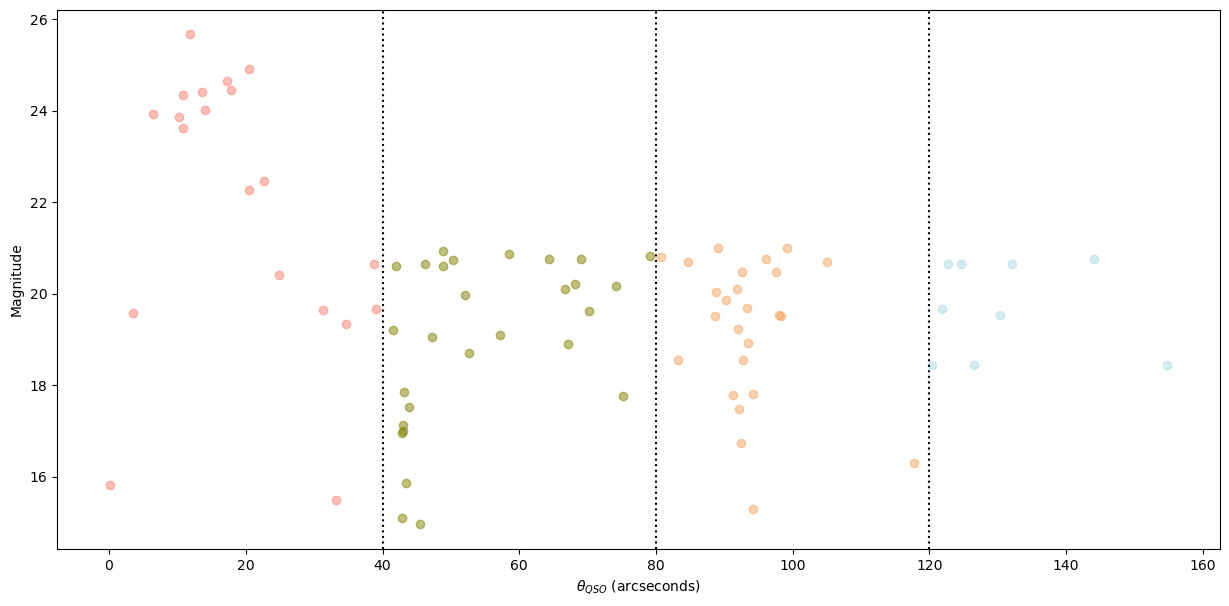

In [28]:
fig, ax = plt.subplots(1, figsize=(15,7))

for i in range(len(theta_sorted)):
    print(len(theta_sorted[i]))
    N_gals += len(theta_sorted[i])
    ax.scatter(theta_sorted[i], mag_sorted[i], color=colors[i], alpha=.5)
    
for j in range(1,len(theta_partitions)-1):
    ax.axvline(theta_partitions[j], color='black', linestyle=':')


ax.set_xlabel(r'$\theta_{QSO}$ (arcseconds)')
ax.set_ylabel('Magnitude')

Isolate the alignment stars

In [29]:
df_alignment_stars = df_sorted.loc[((df_sorted['alignment_star']==1.0)&(df_sorted['f814w_mag']>17)&(df_sorted['f814w_mag']<20))]

In [30]:
df_alignment_stars

,ID,RA,Dec,f814w_mag,alignment_star,theta
9149,9150,117.794011,29.320549,18.32,1.0,33.195566
8109,8110,117.800330,29.320804,19.03,1.0,23.448562
4028,4029,117.818399,29.324493,18.13,1.0,54.727829
5139,5140,117.811502,29.316677,18.58,1.0,49.879550
7146,7147,117.809331,29.345096,18.66,1.0,69.005815
4712,4713,117.821288,29.350535,17.34,1.0,104.730032
644,645,117.831673,29.313349,17.76,1.0,107.824135
10378,10379,117.794235,29.356230,18.48,1.0,106.566928
11146,11147,117.766601,29.304454,17.15,1.0,136.300040
12310,12311,117.771121,29.304193,17.40,1.0,125.887614


Write a regions file to visalize this properly

In [31]:
colors_ds9 = ['pink', 'green', 'yellow', 'cyan', 'white']

In [32]:
with open(rootdir+'ldss_galaxies.reg', 'w') as f:
    
    # Make the annular regions
    #for i in range(1, len(theta_partitions)-1):
    #    f.write('\ncircle(07:51:12.3,+29:19:38.4, {}") #color = gray'.format(theta_partitions[i]))
        
    f.write('#RA Dec Mag')
    # Mark the alignment stars
    for i in range(len(df_alignment_stars)):

        idx = df_alignment_stars.index[i]

        ra = Angle(df_alignment_stars.loc[idx,'RA'], units.deg).hms
        dec = Angle(df_alignment_stars.loc[idx,'Dec'], units.deg).dms
        mag = df_alignment_stars.loc[idx,'f814w_mag']

        ra_label = '%02d'%int(ra[0])+':'+'%02d'%int(ra[1])+':'+'%.2f'%np.round(ra[2],2)
        dec_label = '+'+'%02d'%int(dec[0])+':'+'%02d'%int(dec[1])+':'+'%04.1f'%np.round(dec[2],1)

        f.write('\ncircle('+ra_label+','+dec_label+', 1.0") #color = ' + 'red' + ' text = {'+'%.4f'%np.round(mag, 2)+'}')

    # Mark the galaxies
    for i in range(len(ra_sorted)):

        ra_list = ra_sorted[i]
        dec_list = dec_sorted[i]
        mag_list = mag_sorted[i]
        theta_list = theta_sorted[i]
        priorities_list = priorities_sorted[i]

        for j in range(len(ra_list)):

            ra = Angle(ra_list[j], units.deg).hms
            dec = Angle(dec_list[j], units.deg).dms
            mag = mag_list[j]
            theta = theta_list[j]
            p = priorities_list[j]

            ra_label = '%02d'%int(ra[0])+':'+'%02d'%int(ra[1])+':'+'%.2f'%np.round(ra[2],2)
            dec_label = '+'+'%02d'%int(dec[0])+':'+'%02d'%int(dec[1])+':'+'%04.1f'%np.round(dec[2],1)

            f.write('\ncircle('+ra_label+','+dec_label+', 1.0") #color='+colors_ds9[i]+' text={'+'%.2f'%np.round(mag, 2)+','+'%.2f'%np.round(theta, 2)+','+'%.2f'%np.round(p, 2)+'}')    
    
            
            